## Joke Generator with Review

In [86]:
import os
import random
from dotenv import load_dotenv

from typing import Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field, conlist

import operator

from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command
from langgraph.graph.message import add_messages

from langgraph.checkpoint.memory import MemorySaver

from langchain_openai import ChatOpenAI


from IPython.display import display, Markdown, Image

from langchain_community.document_loaders import RSSFeedLoader

In [2]:
load_dotenv("../.env")

True

## 1. Joke Generator with Review
    - takes in a topic and generates a joke
    - revises the joke twice
    - Asks human for final review

In [4]:
llm = ChatOpenAI(
    temperature=0,
    model="gpt-4o-mini",
    max_tokens=500,
    openai_api_key=os.environ["OPENAI_API_KEY"],
)

In [44]:
class State(TypedDict):
    topic: str
    joke: str
    num_revisions: int

In [48]:
def check_num_revisions(state: State):
    if state["num_revisions"] > 1:
        return "revision_limit_reached"
    return "revise"


def generate_or_revise_joke(state: State):
    if state["num_revisions"] == 0:
        return {
            "joke": llm.invoke(
                f"Write a joke about {state['topic']} with a set up and punchline."
            ),
            "num_revisions": state["num_revisions"] + 1
        }
    else:
        return {
            "joke": llm.invoke(
                f"Revise the joke: {state['joke']}. Refine and make it edgier."
            ),
            "num_revisions": state["num_revisions"] + 1
        }
        
        
graph_builder = StateGraph(State)
graph_builder.add_node("generate_or_revise_joke", generate_or_revise_joke)

graph_builder.add_edge(START, "generate_or_revise_joke")
graph_builder.add_conditional_edges(
    "generate_or_revise_joke",
    check_num_revisions,
    {"revise": "generate_or_revise_joke", "revision_limit_reached": END}
)

graph = graph_builder.compile()

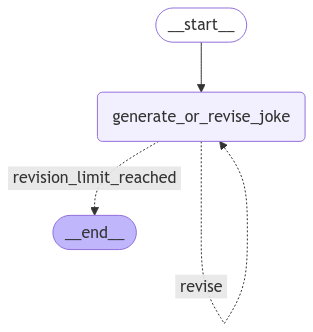

In [49]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
topic = "political correctness"

events = graph.stream(
    {"topic": topic, "num_revisions": 0},
    config = {"configurable": {"thread_id": "1"}},
    stream_mode="values",
)
for event in events:
    if "joke" in event:
        event["joke"].pretty_print()

================================== Ai Message ==================================

Why did the politically correct scarecrow win an award?

Because he was outstanding in his field of sensitivity!
================================== Ai Message ==================================

Why did the politically correct scarecrow get an award?

Because he was truly outstanding in his field—of avoiding all the crows!


## Joke Generator with human topic selection and review

- suggests topics 
- takes human selected topic
- generates a jokes 
- asks human approval
  - approval : End
  - suggestion : takes in suggestion and revise

In [51]:
llm = ChatOpenAI(
    temperature=0,
    model="gpt-4o-mini",
    max_tokens=500,
    openai_api_key=os.environ["OPENAI_API_KEY"],
)

In [142]:
class State(TypedDict):
    topic_list: list[str]
    topic: str
    approval: str
    current_joke: str
    final_joke: str

In [165]:
def generate_topics(state: State):
    return {
        "topic_list": llm.invoke(
            "Generate a list of 5 topics for a joke that can lead to a hilarious joke."
        )
    }

def generate_or_revise_joke(state: State):
    if "approval" not in state:
        return {
            "current_joke": llm.invoke(
                f"Write a joke about {state['topic']} with a set up and punchline."
            ).content
        }
    else:
        return {
            "current_joke": llm.invoke(
                f"Revise the joke: {state['current_joke']}. Refine and make it edgier."
            ).content,
        }
    
def human_topic_selection(state: State):
    value = interrupt(
        f"Please choose a topic from the following list: {state['topic_list']}. Or suggest some other topic.",
    )
    return {"topic": value}


def human_joke_approval(state: State):
    value = interrupt(f"Please approve the joke: {state['current_joke']}. Reply with yes or no.")
    return {"approval": value}


def check_human_joke_approval(state: State):
    if state["approval"].lower() == "yes":
        return "joke_approved"
    return "revise"

def finalize_joke(state: State):
    return {"final_joke": state["current_joke"]}

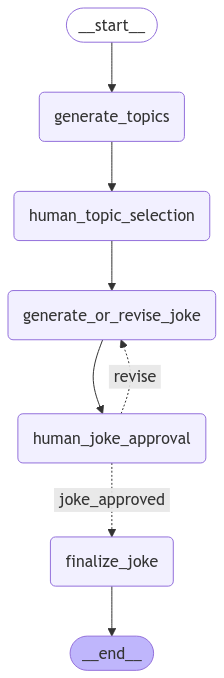

In [166]:
graph_builder = StateGraph(State)
graph_builder.add_node("generate_topics", generate_topics)
graph_builder.add_node("human_topic_selection", human_topic_selection)
graph_builder.add_node("generate_or_revise_joke", generate_or_revise_joke)
graph_builder.add_node("human_joke_approval", human_joke_approval)
graph_builder.add_node("finalize_joke", finalize_joke)

graph_builder.add_edge(START, "generate_topics")
graph_builder.add_edge("generate_topics", "human_topic_selection")
graph_builder.add_edge("human_topic_selection", "generate_or_revise_joke")
graph_builder.add_edge("generate_or_revise_joke", "human_joke_approval")
graph_builder.add_conditional_edges(
    "human_joke_approval",
    check_human_joke_approval,
    {"joke_approved": "finalize_joke", "revise": "generate_or_revise_joke"}
)
graph_builder.add_edge("finalize_joke", END)

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [167]:
config = {"configurable": {"thread_id": "1"}}

In [168]:
# events = graph.stream(
#     {"topic_list": []},
#     config=config,
#     stream_mode="values",
# )
# keys = ["joke", "topic", "approval", "topic_list"]
# for event in events:
#     for key in keys:
#         if key in event:
#             try:
#                 event[key].pretty_print()
#             except:
#                 print(f"{key}: {event[key]}")


# human_response = "Technology fails."

# human_command = Command(resume=human_response)

# events = graph.stream(human_command, config, stream_mode="values")

# keys = ["topic_list", "topic", "approval", "joke"]
# for event in events:
#     for key in keys:
#         if key in event:
#             try:
#                 event[key].pretty_print()
#             except:
#                 print(f"{key}: {event[key]}")
                
# human_response = "Yes"

# human_command = Command(resume=human_response)

# events = graph.stream(human_command, config, stream_mode="values")

# keys = ["topic_list", "topic","joke", "approval"]
# for event in events:
#     for key in keys:
#         if key in event:
#             try:
#                 event[key].pretty_print()
#             except:
#                 print(f"{key}: {event[key]}")

In [169]:
result = graph.invoke({"topic_list": []},config=config,)
print(result.keys())
print(result)

dict_keys(['topic_list'])
{'topic_list': AIMessage(content='Sure! Here are five topics that can lead to some hilarious jokes:\n\n1. **Cats vs. Dogs** - The classic rivalry between pet personalities and their antics.\n2. **Technology Fails** - The humorous side of gadgets and apps that don’t work as intended.\n3. **Cooking Disasters** - The funny mishaps that happen in the kitchen when trying to follow a recipe.\n4. **Awkward First Dates** - The cringe-worthy moments that can happen when meeting someone new.\n5. **Office Life** - The quirks and absurdities of working in a corporate environment.\n\nFeel free to pick one, and I can help you craft a joke!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 137, 'prompt_tokens': 25, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens

In [170]:
result = graph.invoke(Command(resume="Technology Fails"), config=config,)
result

{'topic_list': AIMessage(content='Sure! Here are five topics that can lead to some hilarious jokes:\n\n1. **Cats vs. Dogs** - The classic rivalry between pet personalities and their antics.\n2. **Technology Fails** - The humorous side of gadgets and apps that don’t work as intended.\n3. **Cooking Disasters** - The funny mishaps that happen in the kitchen when trying to follow a recipe.\n4. **Awkward First Dates** - The cringe-worthy moments that can happen when meeting someone new.\n5. **Office Life** - The quirks and absurdities of working in a corporate environment.\n\nFeel free to pick one, and I can help you craft a joke!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 137, 'prompt_tokens': 25, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt

In [171]:
result = graph.invoke(Command(resume="No"), config=config,)
result

{'topic_list': AIMessage(content='Sure! Here are five topics that can lead to some hilarious jokes:\n\n1. **Cats vs. Dogs** - The classic rivalry between pet personalities and their antics.\n2. **Technology Fails** - The humorous side of gadgets and apps that don’t work as intended.\n3. **Cooking Disasters** - The funny mishaps that happen in the kitchen when trying to follow a recipe.\n4. **Awkward First Dates** - The cringe-worthy moments that can happen when meeting someone new.\n5. **Office Life** - The quirks and absurdities of working in a corporate environment.\n\nFeel free to pick one, and I can help you craft a joke!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 137, 'prompt_tokens': 25, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt

In [172]:
result = graph.invoke(Command(resume="Yes"), config=config,)
result

{'topic_list': AIMessage(content='Sure! Here are five topics that can lead to some hilarious jokes:\n\n1. **Cats vs. Dogs** - The classic rivalry between pet personalities and their antics.\n2. **Technology Fails** - The humorous side of gadgets and apps that don’t work as intended.\n3. **Cooking Disasters** - The funny mishaps that happen in the kitchen when trying to follow a recipe.\n4. **Awkward First Dates** - The cringe-worthy moments that can happen when meeting someone new.\n5. **Office Life** - The quirks and absurdities of working in a corporate environment.\n\nFeel free to pick one, and I can help you craft a joke!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 137, 'prompt_tokens': 25, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt

## 3. Joke with help of search engine
- search internet for hot topics or news controversies
- selects 5 topics 
- generates 5 jokes (simultaneously)
- compares jokes
- gives the final joke

In [26]:
llm = ChatOpenAI(
    temperature=0,
    model="gpt-4o-mini",
    max_tokens=500,
    openai_api_key=os.environ["OPENAI_API_KEY"],
)

In [95]:
# creating specialized LLMs for each task
class TopicsOut(BaseModel):
    items: List[str] = Field(
        ..., description="List of exactly 3 topics for a joke, separated by commas."
    )

llm_to_get_topics = llm.with_structured_output(TopicsOut)

class JokeOut(BaseModel):
    joke: str = Field(
        ..., description="The best joke out of the options."
    )
    
llm_to_get_joke = llm.with_structured_output(JokeOut)

urls = [
    "http://feeds.bbci.co.uk/news/world/rss.xml"
]

In [34]:
llm_to_get_topics.invoke(
    "Generate a list of 3 topics for a joke that can lead to a hilarious joke."
)

TopicsOut(items=['cats vs. dogs', 'office coffee machines', 'awkward first dates'])

In [87]:
class State(TypedDict):
    selected_topics: list[str]
    candidate_jokes: Annotated[list, operator.add]
    final_joke: str

In [99]:
def search_new_and_get_topics(state: State):
    loader = RSSFeedLoader(urls=urls)
    data = loader.load()
    news_titles = "\n".join(random.sample([item.metadata["title"] for item in data], 5))
    # print(news_titles)
    return {
        "selected_topics": llm_to_get_topics.invoke(
            f"Given the news headlines : \n{news_titles} \nGenerate a list of 3 topics that can lead to a hilarious joke."
        ).items
    }

def generate_joke_1(state: State):
    return {
        "candidate_jokes": [
            llm.invoke(
                f"Write a joke about {state['selected_topics'][0]} with a set up and punchline."
            ).content
        ]
    }

def generate_joke_2(state: State):
    return {
        "candidate_jokes": [
            llm.invoke(
                f"Write a joke about {state['selected_topics'][1]} with a set up and punchline."
            ).content
        ]
    }

def generate_joke_3(state: State):
    return {
        "candidate_jokes": [
            llm.invoke(
                f"Write a joke about {state['selected_topics'][2]} with a set up and punchline."
            ).content
        ]
    }

def aggregator_comparer(state: State):
    return {
        "final_joke": llm_to_get_joke.invoke(
            f"Compare the following jokes and choose the best one. \n{state['candidate_jokes']}"
        ).joke
    }

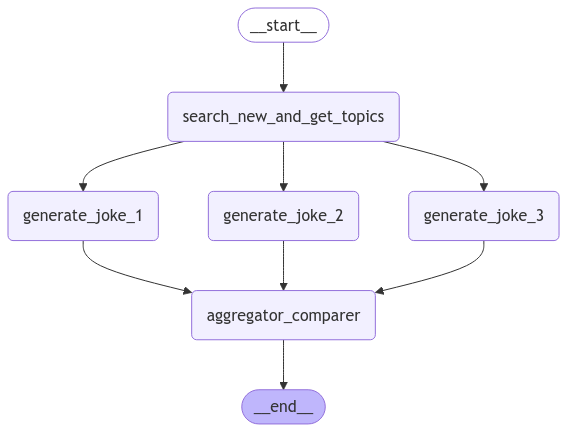

In [100]:
graph_builder = StateGraph(State)
graph_builder.add_node("search_new_and_get_topics", search_new_and_get_topics)  
graph_builder.add_node("generate_joke_1", generate_joke_1)
graph_builder.add_node("generate_joke_2", generate_joke_2)
graph_builder.add_node("generate_joke_3", generate_joke_3)
graph_builder.add_node("aggregator_comparer", aggregator_comparer)

graph_builder.add_edge(START, "search_new_and_get_topics")
graph_builder.add_edge("search_new_and_get_topics", "generate_joke_1")
graph_builder.add_edge("search_new_and_get_topics", "generate_joke_2")
graph_builder.add_edge("search_new_and_get_topics", "generate_joke_3")
graph_builder.add_edge(
    ["generate_joke_1", "generate_joke_2", "generate_joke_3"],
    "aggregator_comparer"
)
graph_builder.add_edge("aggregator_comparer", END)

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [101]:
result = graph.invoke({"selected_topics": []})

In [102]:
result

{'selected_topics': ['Pope Francis and hospital food',
  'Thieves hitting a jackpot with a credit card',
  'The anguish of returning bodies and unexpected surprises'],
 'candidate_jokes': ['Why did Pope Francis bring a fork to the hospital?\n\nBecause he heard the food was heavenly, but he wanted to make sure it was worth the "sacred" calories!',
  'Why did the thieves celebrate after hitting the jackpot with a credit card?  \n\nBecause they finally found a way to make their "interest" pay off!',
  'Why did the archaeologist bring a suitcase to the grave site?\n\nBecause he heard there might be some unexpected "baggage" when returning the bodies!'],
 'final_joke': 'Why did the thieves celebrate after hitting the jackpot with a credit card?  \n\nBecause they finally found a way to make their "interest" pay off!'}

In [3]:
i = True
isinstance(i, bool)

True